# Final Project

In [146]:
import serial, time

ModuleNotFoundError: No module named 'serial'

## Data Collection
Run below cells to collect twitch data

In [ ]:
resolution = 100
duration = 10

# Setup Serial Communication
ser = serial.Serial('COM4') # TODO: Check if correct COM/TTYL port
ser.baudrate = 9600
start_time = time.time()

# Start Data Logging
f = open('{0}.txt'.format(start_time), "w")
while True:
    curr_time = time.time()
    if (curr_time - start_time > duration):
        break
    ser.write(str.encode('l'))
    f.write(str(ser.readline()))
ser.close()
f.close()


NameError: name 'serial' is not defined

## Model Fitting
https://www.tensorflow.org/lite/microcontrollers 

https://github.com/tensorflow/decision-forests

In [ ]:
import sys
!python -m pip install -r requirements.txt

  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached libclang-14.0.6-py2.py3-none-win_amd64.whl (14.2 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached flatbuffers-22.12.6-py2.py3-none-any.whl (26 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached tensorboard-2.11.0-py3-none-any.whl (6.0 MB)
  Using cached termcolor-2.1.1-py3-none-any.whl (6.2 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.utils
from sklearn.model_selection import train_test_split

In [2]:
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

#### Load and Preprocess Data

In [3]:
def load_data(file_num, path=''):
    motion_file = f'{path}/motion/{file_num}_acceleration.txt'
    sleep_file  = f'{path}/labels/{file_num}_labeled_sleep.txt'
    motion_data = pd.read_csv(motion_file, delimiter=' ', names=['time', 'x', 'y', 'z'])
    sleep_data  = pd.read_csv(sleep_file, delimiter=' ', names=['time', 'label'])
    return motion_data, sleep_data

def assign_sleep_to_motion(motion, sleep):
    labels = []
    index = 0
    for t in range(len(motion)):
        labels.append(sleep['label'][index])
        if ((t > sleep['time'][index]) and t < len(sleep['time'])):
            index += 1
    data = np.array([motion['time'], motion['x'], motion['y'], motion['z'], np.array(labels).T]).T
    df = pd.DataFrame(data, columns=['time', 'x', 'y', 'z', 'label'])
    df = df.loc[df['label'] > -1]
    return df

def match_motion_to_sleep(motion, sleep):
    _, _, indices = np.intersect1d(sleep['time'], motion['time'], return_indices=True)
    data = np.array([sleep['time'], 
                    motion['x'][indices], 
                    motion['y'][indices], 
                    motion['z'][indices], 
                    sleep['label']]).T
    df = pd.DataFrame(data, columns=['time', 'x', 'y', 'z', 'label'])
    df = df.loc[df['label'] > -1]
    return df

def get_motion_average(motion):
    motion_time, motion_indices = np.unique(np.floor(motion['time']), return_index=True)
    avg_x = np.array([np.average(motion['x'][i]) for i in motion_indices])
    avg_y = np.array([np.average(motion['y'][i]) for i in motion_indices])
    avg_z = np.array([np.average(motion['z'][i]) for i in motion_indices])
    data = np.array([motion_time, avg_x, avg_y, avg_z]).T
    df = pd.DataFrame(data, columns=['time', 'x', 'y', 'z'])
    return df

def plot_data(df, title=''):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_title(title)
    plot = lambda d, c, m : ax.scatter3D(d['x'], d['y'], d['z'], c=c, marker=m)
    colors = ['r', 'm', 'y', 'g', 'b', 'c']
    [plot(df.loc[df['label'] == i], colors[i], '.') for i in range(6)]
    

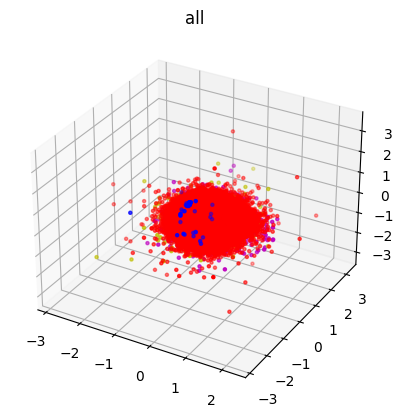

In [4]:
file_nums = ['46343', '781756', '844359', '1066528', '1449548', '1818471', '2598705', '2638030', '3997827', 
'4018081', '4314139', '4426783', '5383425', '5498603', '5797046', '6220552', '7749105', '8000685', '8173033',
'8258170', '8686948', '9961348']
prep_func = lambda d: assign_sleep_to_motion(get_motion_average(d[0]), d[1])
# data = [load_data(file_nums[i], './data') for i in range(0, 1)]
data = [load_data(num, './data') for num in file_nums]
df = pd.concat([prep_func(d) for d in data], axis=0, ignore_index=True)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title("all")
plot = lambda d, c, m : ax.scatter3D(d['x'], d['y'], d['z'], c=c, marker=m)
colors = ['r', 'm', 'y', 'g', 'b', 'c']
[plot(df.loc[df['label'] == i], colors[i], '.') for i in range(6)]

In [5]:
train, test = train_test_split(df, test_size=0.2)
train, valid = train_test_split(train, test_size=0.25)
x_train, y_train = train[['x', 'y', 'z']].to_numpy(), train['label'].to_numpy()
x_valid, y_valid = valid[['x', 'y', 'z']].to_numpy(), valid['label'].to_numpy()
x_test, y_test = test[['x', 'y', 'z']].to_numpy(), test['label'].to_numpy()

#### Train Model

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, MaxPooling2D,Flatten,Dropout,Dense

In [7]:
# Simple Neural Network
class argmax_layer(Layer):
  def __init__(self):
    super(argmax_layer, self).__init__()

  def call(self, inputs):
    return tf.math.argmax(inputs, axis=1)

model = tf.keras.Sequential()
model.add(keras.layers.Dense(8, activation='relu', input_shape=(3,)))
model.add(keras.layers.Dense(6))
# model.add(argmax_layer())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 32        
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


In [8]:
%%capture
# Compile and fit
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid))

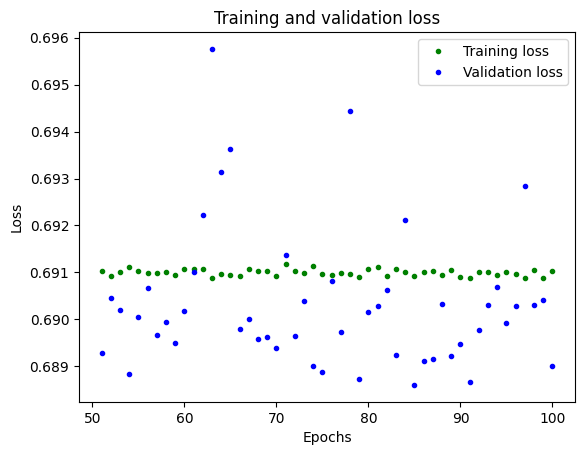

In [9]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

SKIP = 50

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

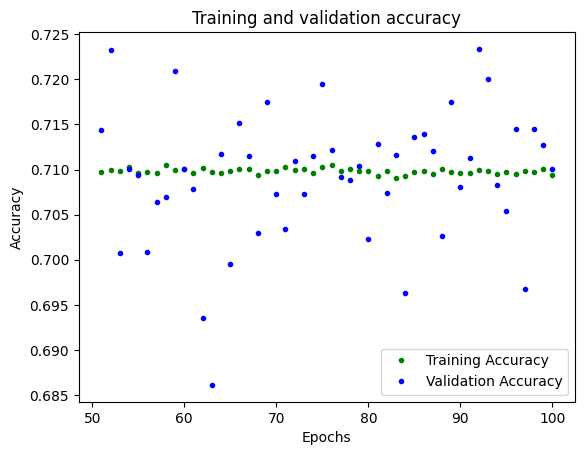

In [10]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs[SKIP:], train_acc[SKIP:], 'g.', label='Training Accuracy')
plt.plot(epochs[SKIP:], val_acc[SKIP:], 'b.', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2173/2173 [==============================] - 1s 434us/step


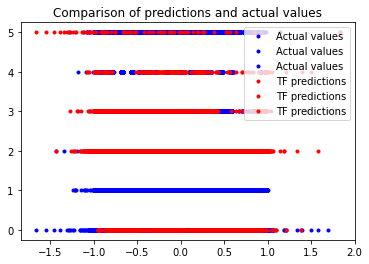

In [169]:
# Calculate and print the loss on our test dataset
test_loss, test_acc = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)
y_test_pred_label = np.argmax(y_test_pred, axis=1)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred_label, 'r.', label='TF predictions')
plt.legend()
plt.show()

#### Convert Tflite model for microcontroler

In [16]:
# def representative_dataset():
#     for _ in range(500):
#       data = np.random.rand(1,3)
#       yield [data.astype(np.float32)]

In [13]:
# Convert and sove
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8
# converter.representative_dataset = representative_dataset
tflite_model = converter.convert()
with open('model/model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\leona\AppData\Local\Temp\tmp2zw9wsrv\assets


INFO:tensorflow:Assets written to: C:\Users\leona\AppData\Local\Temp\tmp2zw9wsrv\assets


TypeError: EndVector() takes 1 positional argument but 2 were given

In [10]:
!xxd -i model/model.tflite > model/model.cpp
# Update variable names
REPLACE_TEXT = 'model/model.tflite'.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {'model/model.cpp'}
!cp model/model.cpp lib/model/model.cpp